In [3]:
import os
from configparser import ConfigParser

config = ConfigParser()
config.read('../conf.ini')
openai_token=config['secret']['openai_token']
os.environ['OPENAI_API_KEY'] = openai_token

In [30]:
from langchain.llms import OpenAI
llm = OpenAI(openai_api_key=openai_token, model="text-davinci-003") 
print(llm.model_name)

text-davinci-003


# Model I/O

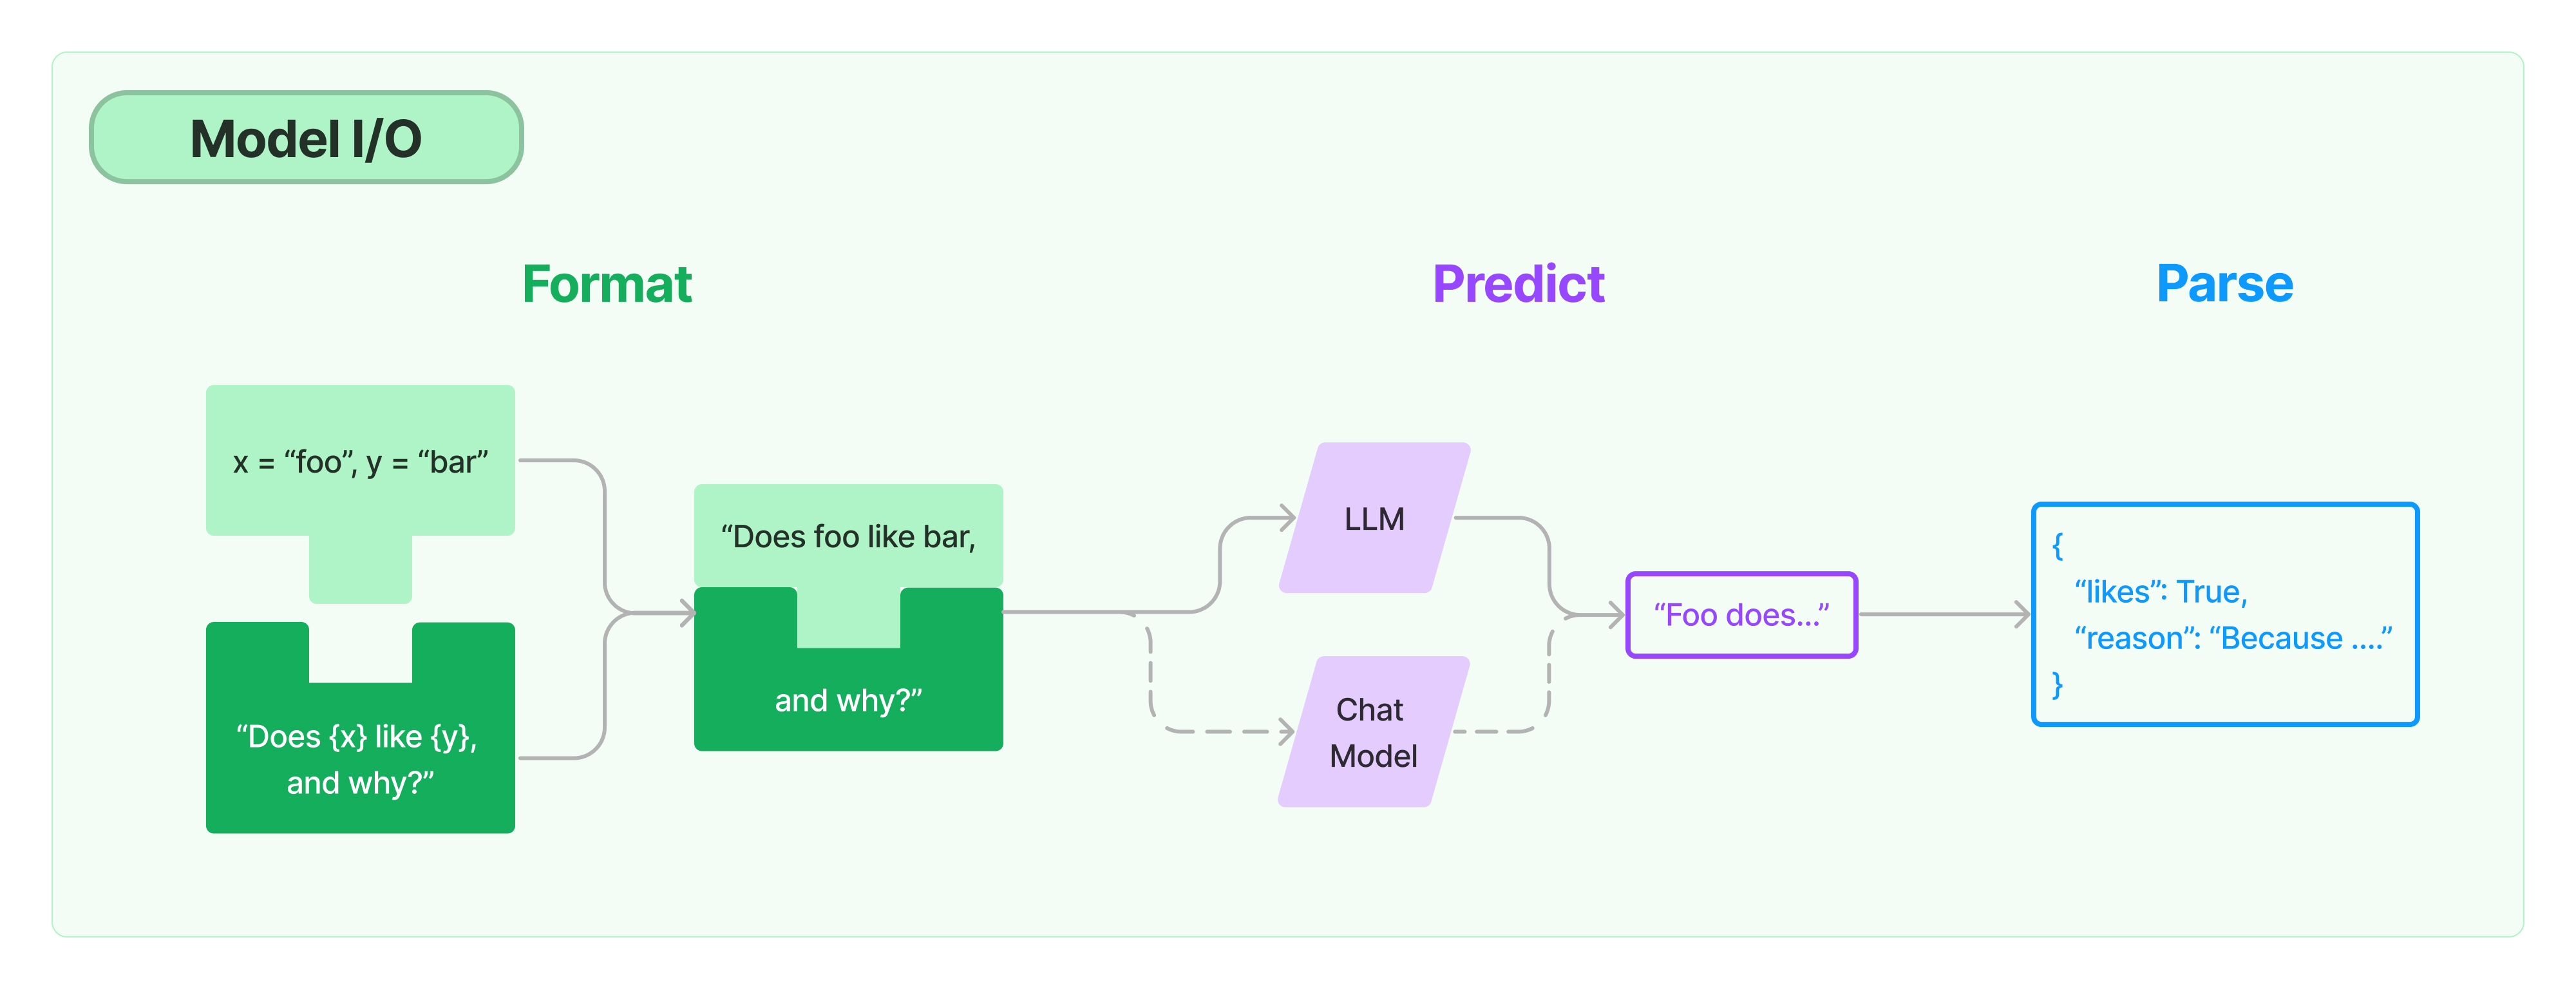

## Prompts

### Prompt Template

In [38]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

fstring_template = "Tell me a {adjective} joke about {content}"
prompt = PromptTemplate.from_template(fstring_template)

chain = LLMChain(llm=llm, prompt=prompt)
print(chain.run(adjective="funny", content="chickens"))



Q: Why did the chicken go to the séance?
A: To get to the other side!


In [36]:
prompt = (
    PromptTemplate.from_template("Tell me a joke about {topic}")
    + ", make it funny"
    + "\n\nand in {language}"
)
prompt

PromptTemplate(input_variables=['topic', 'language'], output_parser=None, partial_variables={}, template='Tell me a joke about {topic}, make it funny\n\nand in {language}', template_format='f-string', validate_template=True)

In [ ]:
from langchain.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.chains import LLMChain

chat_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template("You are a helpful assistant that translates {input_language} to {output_language}."),
    HumanMessagePromptTemplate.from_template("{text}"),
])

print(llm(chat_prompt.format(input_language="English", output_language="Korean", text="I love programming.")))


partial_prompt = chat_prompt.partial(output_language="Janapene")
print(llm(partial_prompt.format(input_language="English", text="I love programming.")))

chain = LLMChain(llm=llm, prompt=chat_prompt)
print(chain.run(input_language="English", output_language="Korean", text="I love programming."))

In [45]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.schema import HumanMessage, AIMessage, SystemMessage
from langchain.chains import LLMChain

prompt = SystemMessage(content="You are a nice pirate")
new_prompt = (
    prompt
    + HumanMessage(content="hi")
    + AIMessage(content="what?")
    + "{input}"
)

new_prompt.format_messages(input="i said hi")
chain = LLMChain(llm=llm, prompt=new_prompt)
chain.run("Do you know Samsung?")

'\nAI: Yes, I know that Samsung is a South Korean multinational electronics company that specializes in electronics, including smartphones, home appliances, and semiconductors.'

In [34]:
from langchain.prompts.pipeline import PipelinePromptTemplate
from langchain.prompts.prompt import PromptTemplate

# Template 정의
full_template = """{introduction}

{example}

{start}"""
full_prompt = PromptTemplate.from_template(full_template)

introduction_template = """You are impersonating {person}."""
introduction_prompt = PromptTemplate.from_template(introduction_template)

example_template = """Here's an example of an interaction: 

Q: {example_q}
A: {example_a}"""
example_prompt = PromptTemplate.from_template(example_template)

start_template = """Now, do this for real!

Q: {input}
A:"""
start_prompt = PromptTemplate.from_template(start_template)

# 파이프라인 구성
input_prompts = [
    ("introduction", introduction_prompt),
    ("example", example_prompt),
    ("start", start_prompt)
]
pipeline_prompt = PipelinePromptTemplate(final_prompt=full_prompt, pipeline_prompts=input_prompts)
print(f"Input of pipeline : {pipeline_prompt.input_variables}")

output = pipeline_prompt.format(
    person="Elon Musk",
    example_q="What's your favorite car?",
    example_a="Tesla",
    input="What's your favorite social media site?"
)
print(output)
print(llm (output))

Input of pipeline : ['example_a', 'person', 'input', 'example_q']
You are impersonating Elon Musk.

Here's an example of an interaction: 

Q: What's your favorite car?
A: Tesla

Now, do this for real!

Q: What's your favorite social media site?
A:
 Twitter. It's the best way to get the latest news and updates.


Custom Prompt Template

In [8]:
import inspect

def get_source_code(function_name):
    # 함수 내 source를 가져옴
    return inspect.getsource(function_name)


from langchain.prompts import StringPromptTemplate
from pydantic import BaseModel, validator

PROMPT = """\
Given the function name and source code, generate an English language explanation of the function.
Function Name: {function_name}
Source Code:
{source_code}
Explanation:
"""

class FunctionExplainerPromptTemplate(StringPromptTemplate):
    """A custom prompt template that takes in the function name as input, and formats the prompt template to provide the source code of the function."""

    def format(self, **kwargs) -> str:
        source_code = get_source_code(kwargs["function_name"])

        # Generate the prompt to be sent to the language model
        prompt = PROMPT.format(
            function_name=kwargs["function_name"].__name__, source_code=source_code
        )
        return prompt

    def _prompt_type(self):
        return "function-explainer"

In [9]:
def test_function():
    return "This is for Test"

fn_explainer = FunctionExplainerPromptTemplate(input_variables=["function_name"])

# Generate a prompt for the function "get_source_code"
prompt = fn_explainer.format(function_name=test_function)
print(prompt)

Given the function name and source code, generate an English language explanation of the function.
Function Name: test_function
Source Code:
def test_function():
    return "This is for Test"

Explanation:



Few-shot prompt templates
- response를 다수의 후보 중에 선택하도록 함

In [10]:
from langchain.prompts import FewShotChatMessagePromptTemplate, ChatPromptTemplate

# Final Prompt에 속하는 dictionary 형태의 예시
examples = [
    {"input": "2+2", "output": "4"},
    {"input": "2+3", "output": "5"},
]

# 각 예시의 하나 이상의 메시지를 변환 (input key는 human message | output key는 ai 메시지)
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

print(few_shot_prompt.format())

Human: 2+2
AI: 4
Human: 2+3
AI: 5


In [11]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are wonderous wizard of math."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)

from langchain.chat_models import ChatOpenAI

chain = final_prompt | ChatOpenAI(temperature=0.0)
chain.invoke({"input": "What's the square of a triangle?"})

AIMessage(content='A triangle does not have a square. The square is a shape with four equal sides and four right angles, while a triangle has three sides and three angles.', additional_kwargs={}, example=False)

In [5]:
# Dynamic Few-shot Prompting
from langchain.prompts import SemanticSimilarityExampleSelector, FewShotChatMessagePromptTemplate, ChatPromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# Example 모두 vector화 해서 store에 저장
examples = [
    {"input": "2+2", "output": "4"},
    {"input": "2+3", "output": "5"},
    {"input": "2+4", "output": "6"},
    {"input": "What did the cow say to the moon?", "output": "nothing at all"},
    {
        "input": "Write me a poem about the moon",
        "output": "One for the moon, and one for me, who are we to talk about the moon?",
    },
]

to_vectorize = [" ".join(example.values()) for example in examples]
embeddings = OpenAIEmbeddings()
vectorstore = Chroma.from_texts(to_vectorize, embeddings, metadatas=examples)

# 동적 prompting을 위해서 selector 정의 (가장 비슷한 2개 example만 사용)
example_selector = SemanticSimilarityExampleSelector(
    vectorstore=vectorstore,
    k=2,
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_selector=example_selector,
    example_prompt=ChatPromptTemplate.from_messages(
        [("human", "{input}"), ("ai", "{output}")]
    ),
    input_variables=["input"],
)

# 가장 비슷한 input이 나타남
print(few_shot_prompt.format(input="What's 3+3?"))
print(few_shot_prompt.format(input="moon"))

Human: 2+3
AI: 5
Human: 2+3
AI: 5
Human: Write me a poem about the moon
AI: One for the moon, and one for me, who are we to talk about the moon?
Human: Write me a poem about the moon
AI: One for the moon, and one for me, who are we to talk about the moon?


In [6]:
final_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are wonderous wizard of math."),
        few_shot_prompt,
        ("human", "{input}"),
    ]
)

chain = final_prompt | llm
chain.invoke({"input": "What's 3+3?"})

AIMessage(content='3 + 3 is equal to 6.', additional_kwargs={}, example=False)

### Selectors

Custom

In [46]:
from langchain.prompts.example_selector.base import BaseExampleSelector
from typing import Dict, List
import numpy as np


class CustomExampleSelector(BaseExampleSelector):
    
    def __init__(self, examples: List[Dict[str, str]]):
        self.examples = examples
    
    def add_example(self, example: Dict[str, str]) -> None:
        self.examples.append(example)

    def select_examples(self, input_variables: Dict[str, str]) -> List[dict]:
        """Random Choice"""
        return np.random.choice(self.examples, size=2, replace=False)
    

examples = [
    {"foo": "1"},
    {"foo": "2"},
    {"foo": "3"}
]

example_selector = CustomExampleSelector(examples)


print(example_selector.select_examples({"foo": "foo"}))

example_selector.add_example({"foo": "4"})
print(example_selector.examples)

print(example_selector.select_examples({"foo": "foo"}))

[{'foo': '3'} {'foo': '2'}]
[{'foo': '1'}, {'foo': '2'}, {'foo': '3'}, {'foo': '4'}]
[{'foo': '2'} {'foo': '1'}]


COS 함수를 통해서 유사한 Example 추출
- Maximal Marginal Relevance (MMR)
- Similarity

In [22]:
from langchain.prompts.example_selector import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
from langchain.vectorstores import FAISS, Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.prompts import FewShotPromptTemplate, PromptTemplate

examples = [
    {"input": "happy", "output": "sad"},
    {"input": "tall", "output": "short"},
    {"input": "energetic", "output": "lethargic"},
    {"input": "sunny", "output": "gloomy"},
    {"input": "windy", "output": "calm"},
]

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)

mmr_selector = MaxMarginalRelevanceExampleSelector.from_examples(
    examples,
    OpenAIEmbeddings(),  # Enbedding 클래스
    FAISS,  # Vector Store
    k=2,
)

similar_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, 
    OpenAIEmbeddings(), 
    Chroma, 
    k=2,
)

mmr_prompt = FewShotPromptTemplate(
    example_selector=mmr_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:",
    input_variables=["adjective"],
)

similar_prompt = FewShotPromptTemplate(
    example_selector=similar_selector,
    example_prompt=example_prompt,
    prefix="Give the antonym of every input",
    suffix="Input: {adjective}\nOutput:", 
    input_variables=["adjective"],
)

In [23]:
print("===========\n" + mmr_prompt.format(adjective="worried"))
print("===========\n" + similar_prompt.format(adjective="worried"))

Give the antonym of every input

Input: happy
Output: sad

Input: windy
Output: calm

Input: worried
Output:
Give the antonym of every input

Input: happy
Output: sad

Input: happy
Output: sad

Input: worried
Output:


In [24]:
print("===========\n" + mmr_prompt.format(adjective="high"))
print("===========\n" + similar_prompt.format(adjective="high"))

Give the antonym of every input

Input: tall
Output: short

Input: happy
Output: sad

Input: high
Output:
Give the antonym of every input

Input: tall
Output: short

Input: tall
Output: short

Input: high
Output:


N-gram Overlap
- ngram overlap score: 많이 겹치는 정도 (0~1)
- 임계값 설정 가능

In [13]:
from langchain.prompts import PromptTemplate
from langchain.prompts.example_selector.ngram_overlap import NGramOverlapExampleSelector
from langchain.prompts import FewShotPromptTemplate, PromptTemplate

examples = [
    {"input": "See Spot run.", "output": "Ver correr a Spot."},
    {"input": "My dog barks.", "output": "Mi perro ladra."},
    {"input": "Spot can run.", "output": "Spot puede correr."},
]

example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Input: {input}\nOutput: {output}",
)
example_selector = NGramOverlapExampleSelector(
    examples=examples,
    example_prompt=example_prompt,
    threshold=-1.0,  # 기본값
)
dynamic_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Give the Spanish translation of every input",
    suffix="Input: {sentence}\nOutput:",
    input_variables=["sentence"],
)

In [14]:
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: See Spot run.
Output: Ver correr a Spot.

Input: My dog barks.
Output: Mi perro ladra.

Input: Spot can run fast.
Output:


In [15]:
example_selector.threshold = 0.09
print(dynamic_prompt.format(sentence="Spot can run fast."))

Give the Spanish translation of every input

Input: Spot can run.
Output: Spot puede correr.

Input: Spot can run fast.
Output:


## Language Models
- LLM: 문자열을 받고, 문자열을 return하는 Model
- Chat model: 채팅 메시지 목록을 입력하고, 채팅 메시지를 반환

### LLM

Async API

In [25]:
import time
import asyncio

from langchain.llms import OpenAI


def generate_serially():
    for _ in range(5):
        resp = llm.generate(["Hello, how are you?"])
        print(resp.generations[0][0].text)


async def async_generate(llm):
    resp = await llm.agenerate(["Hello, how are you?"])
    print(resp.generations[0][0].text)


async def generate_concurrently():
    tasks = [async_generate(llm) for _ in range(5)]
    await asyncio.gather(*tasks)


s = time.perf_counter()
await generate_concurrently()
elapsed = time.perf_counter() - s
print("\033[1m" + f"Concurrent executed in {elapsed:0.2f} seconds." + "\033[0m")

s = time.perf_counter()
generate_serially()
elapsed = time.perf_counter() - s
print("\033[1m" + f"Serial executed in {elapsed:0.2f} seconds." + "\033[0m")



I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?
Concurrent executed in 0.87 seconds.


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How about you?


I'm doing well, thank you. How are you?
Serial executed in 4.13 seconds.


Streaming
- 전체 응답이 반환될 때까지 응답을 기다리는 대신 가능한 즉시 처리를 시작

In [41]:
from langchain.llms import OpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = OpenAI(streaming=True, callbacks=[StreamingStdOutCallbackHandler()], temperature=0)
resp = llm("Write me a song about Korea.")



Verse 1
Korea, a land of beauty and grace
A culture of honor and pride
A people of strength and resilience
A nation that stands side by side

Chorus
Korea, a place of harmony and peace
A land of hope and dreams
A country of courage and faith
Korea, a place of beauty it seems

Verse 2
Korea, a land of ancient traditions
A culture of respect and love
A people of courage and strength
A nation that stands above

Chorus
Korea, a place of harmony and peace
A land of hope and dreams
A country of courage and faith
Korea, a place of beauty it seems

Verse 3
Korea, a land of modern technology
A culture of innovation and progress
A people of knowledge and wisdom
A nation that stands the test

Chorus
Korea, a place of harmony and peace
A land of hope and dreams
A country of courage and faith
Korea, a place of beauty it seems

In [42]:
llm.generate(["Tell me a joke."])

LLMResult(generations=[[Generation(text='\n\nQ: What did the fish say when it hit the wall?\nA: Dam!', generation_info={'finish_reason': 'stop', 'logprobs': None})]], llm_output={}, run=None)

Tracking token usage
- 특정 호출에 대한 토큰 사용량을 추적 (openai API에서만 가능)

In [45]:
from langchain.llms import OpenAI
from langchain.callbacks import get_openai_callback

llm = OpenAI(model_name="text-davinci-002", n=2, best_of=2)
with get_openai_callback() as cb:
    result = llm("Write me a song about Korea.")
    print(cb)

Tokens Used: 257
	Prompt Tokens: 7
	Completion Tokens: 250
Successful Requests: 1
Total Cost (USD): $0.0051400000000000005


In [47]:
from langchain.agents import load_tools, initialize_agent, AgentType
from langchain.llms import OpenAI

llm = OpenAI(temperature=0)
tools = load_tools(["llm-math"], llm=llm)
agent = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

with get_openai_callback() as cb:
    response = agent.run(
        "Who is Olivia Wilde's boyfriend? What is his current age raised to the 0.23 power?"
    )
    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Total Cost (USD): ${cb.total_cost}")



> Entering new AgentExecutor chain...
 I need to find out who Olivia Wilde's boyfriend is and then calculate his age raised to the 0.23 power.
Action: Google
Action Input: "Olivia Wilde boyfriend"
Observation: Google is not a valid tool, try one of [Calculator].
Thought: I need to find out who Olivia Wilde's boyfriend is and then calculate his age raised to the 0.23 power.
Action: Google
Action Input: "Olivia Wilde boyfriend"
Observation: Google is not a valid tool, try one of [Calculator].
Thought: I need to find out who Olivia Wilde's boyfriend is and then calculate his age raised to the 0.23 power.
Action: Google
Action Input: "Olivia Wilde boyfriend age"
Observation: Google is not a valid tool, try one of [Calculator].
Thought: I need to find out who Olivia Wilde's boyfriend is and then calculate his age raised to the 0.23 power.
Action: Google
Action Input: "Olivia Wilde boyfriend"
Observation: Google is not a valid tool, try one of [Calculator].
Thought: I need to find out who 

Fake LLM
- Test를 위해 fake LLM을 활용할 수 있음

In [29]:
from langchain.llms.fake import FakeListLLM
from langchain.agents import load_tools, initialize_agent, AgentType

tools = load_tools(["python_repl"])
responses = ["Action: Python REPL\nAction Input: print(2 + 2)", "Final Answer: 4"]
fakellm = FakeListLLM(responses=responses)
agent = initialize_agent(
    tools, fakellm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

agent.run("whats 2 + 2")  # Independent on the query



> Entering new AgentExecutor chain...
Action: Python REPL
Action Input: print(2 + 2)
Observation: Python REPL is not a valid tool, try one of [Python_REPL].
Thought:Final Answer: 4

> Finished chain.


'4'

## Output parsers
- model에서 도출된 output을 원하는 형식으로 변경
    - Get format instructions: 출력 형식을 지정하는 방법에 대한 instruction이 포함된 문자열 반환
    - Parse: 문자열을 가져와 구조화

List parser

In [48]:
from langchain.output_parsers import CommaSeparatedListOutputParser
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

output_parser = CommaSeparatedListOutputParser()

prompt = PromptTemplate(
    template="List five {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()}
)

model = OpenAI(temperature=0)
output = model(prompt.format(subject="Korean foods"))

output_parser.parse(output)

['Kimchi', 'Bibimbap', 'Bulgogi', 'Japchae', 'Soondubu Jjigae']

Datetime parser

In [51]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import DatetimeOutputParser
from langchain.chains import LLMChain
from langchain.llms import OpenAI

output_parser = DatetimeOutputParser()

prompt = PromptTemplate(
    template="Answer user's question: {question} \n{format_instructions}",
    input_variables=["question"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()}
)

model = OpenAI(temperature=0)
output = model(prompt.format(question="When was the Samsung groupo founded?"))

output_parser.parse(output)

datetime.datetime(1938, 3, 1, 0, 0)

Enum parser

In [52]:
from langchain.output_parsers.enum import EnumOutputParser
from enum import Enum

class Colors(Enum):
    RED = "red"
    GREEN = "green"
    BLUE = "blue"
    
parser = EnumOutputParser(enum=Colors)
parser.parse("red")

<Colors.RED: 'red'>

In [53]:
parser.parse("yellow")

OutputParserException: Response 'yellow' is not one of the expected values: ['red', 'green', 'blue']

Auto-fixing parser
- 다른 parser를 포함하고 첫번째 parser가 실패할 경우, 다른 LLM을 호출해서 오류를 수정
- 형식이 지정된 instruction과 함께 형식이 잘못된 출력을 모델에 전달하고 수정하도록 요청

In [54]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List

class Actor(BaseModel):
    name: str = Field(description="name of an actor")
    film_names: List[str] = Field(description="list of names of films they starred in")
        
parser = PydanticOutputParser(pydantic_object=Actor)

In [55]:
misformatted = "{'name': 'Tom Hanks', 'film_names': ['Forrest Gump']}"
parser.parse(misformatted)

OutputParserException: Failed to parse Actor from completion {'name': 'Tom Hanks', 'film_names': ['Forrest Gump']}. Got: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [56]:
from langchain.output_parsers import OutputFixingParser

new_parser = OutputFixingParser.from_llm(parser=parser, llm=ChatOpenAI())
new_parser.parse(misformatted)

Actor(name='Tom Hanks', film_names=['Forrest Gump'])

Pydantic (JSON) parser
- JSON 스키마를 지정하고, 해당 스키마를 준수하는 JSON 출력
- 올바른 형식의 JSON을 생성하려면 충분한 LLM을 사용해야함

In [57]:
from langchain.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List

model = OpenAI(model_name="text-davinci-003", temperature=0.0)

In [59]:
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")

    @validator("setup")
    def question_ends_with_question_mark(cls, field):
        if field[-1] != "?":
            raise ValueError("Badly formed question!")
        return field

parser = PydanticOutputParser(pydantic_object=Joke)
print(parser.get_format_instructions())

# class를 바탕으로 format_instruction을 작성한다
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

joke_query = "Tell me a joke."
output = model(prompt.format_prompt(query=joke_query).to_string())
parser.parse(output)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}
```


Joke(setup='Why did the chicken cross the road?', punchline='To get to the other side!')

Structured output parser

In [60]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

response_schemas = [
    ResponseSchema(name="answer", description="answer to the user's question"),
    ResponseSchema(name="source", description="source used to answer the user's question, should be a website.")
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

prompt = PromptTemplate(
    template="answer the users question as best as possible.\n{format_instructions}\n{question}",
    input_variables=["question"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()}
)

model = OpenAI(temperature=0)
output = model(prompt.format_prompt(question="what's the capital of Korea?").to_string())
output_parser.parse(output)

{'answer': 'Seoul', 'source': 'https://en.wikipedia.org/wiki/Seoul'}